In [1]:
import sys
sys.path.append("../src")

import jax
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)

import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## Example of Algorithm 1: with $b$ as Brownian Bridge drift

This is an example of a transport from Brownian bridge to Posteior.


In [2]:

potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


In [3]:
key = jax.random.key(0)

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 500, 'batch_size' :500}

brownian_bridge_drift = lambda x,t: (1.0 - x)/(1-t)

ndims = 1


# likelihood function
def make_J_brownian_bridge(dt, V):
    def J_brownian_bridge(x, y):
        nabla_V = jax.grad(V)
        laplacian_of_potential = jax.vmap(lambda k: jnp.trace(jax.jacfwd(nabla_V)(k)))(x)
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)

# b = uref # initialize b as uref
# schedule = np.linspace(0,1,11) 
schedule = [0.1,0.5,1.0]

rho = lambda key: jnp.zeros((ndims,))-1.   #initialization
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 
V = make_double_well_potential(v=5.0)
b = brownian_bridge_drift
A_TH = 0

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)

    b, A = update_non_amortized(
        V=V,   # not used with SPDE off
        b=b,   # prior drift
        J=make_J_brownian_bridge(hyperparams['dt'], V),
        prior='brownian',
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        A_TH=A_TH,
        refine=False
    )
    


KeyboardInterrupt: 

## Rerun with SPDE turned on

s:  0.0
Train loss: 1817534.75
s:  0.1
Train loss: 120.92413330078125
s:  0.5
Train loss: 113.57476043701172


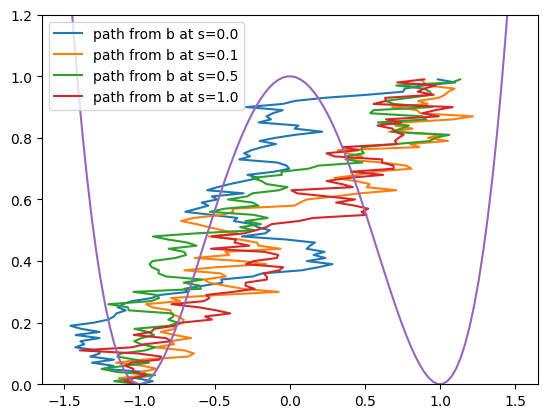

In [5]:
key = jax.random.key(0)

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :250}

brownian_bridge_drift = lambda x,t: (1.0 - x)/(1-t)

ndims = 1


# likelihood function
def make_J_brownian_bridge(dt, V):
    def J_brownian_bridge(x, y):
        nabla_V = jax.grad(V)
        laplacian_of_potential = jax.vmap(lambda k: jnp.trace(jax.jacfwd(nabla_V)(k)))(x)
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)

# b = uref # initialize b as uref
# schedule = np.linspace(0,1,11) 
schedule = [0.1,0.5,1.0]

rho = lambda key: jnp.zeros((ndims,))-1.   #initialization
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 
    
V = make_double_well_potential(v=5.0)   # V is the double-well potential
b = brownian_bridge_drift
A_TH = 0

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)

    b, A = update_non_amortized(
        V=lambda x: s*V(x),   # this is used in SPDE (it's scaled by s since we are gradually introducing the potential) 
        b=b,   # prior drift
        J=make_J_brownian_bridge(hyperparams['dt'], V),
        prior='brownian',
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        A_TH=A_TH,
        refine=False
    )

# plot double well potential
potential = make_double_well_potential(v=1.0)
x = jnp.expand_dims(jnp.linspace(-1.5, 1.5, 100), 1)
y = potential(x)
# limit y axis to 5
plt.ylim(0, 1.2)
plt.plot(x, y)
    
